In [9]:
import sys
import torch.nn as nn
import torch
import warnings
import numpy as np
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
    
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]
    
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        
    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def validation_step(self, batch, plot_flag=True):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if plot_flag:
            self.plot('loss', l, train=False)
        return l

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

def stat_val(model, data):
    ppls = []
    for batch in iter(data.get_dataloader(False)):
        ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
    return np.exp(np.mean(ppls))

def experiment(model, data):
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
    trainer.fit(model, data)
    return stat_val(model, data)

# 1. Can you adjust the hyperparameters to improve the translation results?

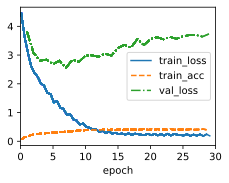

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
param_grid = {'embed_size':[128, 256, 512],
              'num_hiddens':[128, 256, 512],
              'num_layers':[1,2,3],
              'dropout':[0, 0.1, 0.2, 0.5]
              # 'lr':[0.001,0.003,0.005, 0.01]
             }
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), **params)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), **params)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
    ppl = experiment(model, data)
    ppls.append(ppl)
    print(params, ppl)

# 2. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?

In [ ]:
class NoMaskSeq2Seq(Seq2Seq):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        
    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        return l.mean()

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = NoMaskSeq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

# 3. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?

In [ ]:
class DiffSeq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        tran = nn.LazyLinear(self.num_hiddens*self.num_layers)
        H = enc_all_outputs[1].swapaxes(0, 1)
        H = H.reshape(H.shape[0], -1)
        S = tran(H)
        S = S.reshape(S.shape[0],-1, self.num_hiddens)
        S = S.swapaxes(0, 1)
        return enc_all_outputs[0], S

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = self.init_state(state)
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]
    

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = DiffSeq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens*2, num_layers+1, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

# 4. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?

In [ ]:
class NoTeacherForceSeq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        context = context.repeat(1, 1, 1)
        outputs = []
        for _ in range(embs.shape[0]):
            embs_and_context = torch.cat((embs[i:i+1], context), -1)
            Y, hidden_state = self.rnn(embs_and_context, hidden_state)
            outputs.append(Y)
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        outputs = torch.cat(outputs,0)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = NoTeacherForceSeq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

# 5. Rerun the experiment by replacing GRU with LSTM.

In [ ]:
class LSTM(d2l.RNN):
    """The multilayer GRU model.

    Defined in :numref:`sec_deep_rnn`"""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)
        
class LSTMSeq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)
    
class LSTMSeq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = LSTMSeq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = LSTMSeq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

# 6. Are there any other ways to design the output layer of the decoder?

There are several ways to design the output layer of the decoder in addition to using `nn.Linear`. The choice of the output layer design often depends on the specific task you are working on and the characteristics of your data. Here are some alternative ways to design the output layer:

1. **Softmax Layer**: For tasks like sequence generation, machine translation, or language modeling, you can use a softmax layer as the output layer. This layer converts the decoder's hidden states into probability distributions over the vocabulary. Each element in the output represents the probability of a particular word in the vocabulary.

2. **Linear Layer with Custom Activation**: Instead of using a simple linear layer, you can apply a custom activation function to the linearly transformed hidden states. For example, you can use a sigmoid activation for binary classification tasks or a hyperbolic tangent (tanh) for bounded outputs.

3. **Attention Mechanism**: In sequence-to-sequence models with attention, the output layer is often combined with an attention mechanism. This allows the model to focus on specific parts of the input sequence when generating the output sequence. The output layer takes into account both the decoder's hidden state and the context vector obtained from attention.

4. **Gated Layers**: For more complex sequence generation tasks, you can use gated layers like Gated Recurrent Units (GRUs) or Long Short-Term Memory (LSTM) units as the output layer. These layers have internal gating mechanisms that can capture long-range dependencies and improve sequence generation.

5. **Custom Output Layer**: Depending on your specific task, you can design a custom output layer that suits the problem's requirements. This could involve using a combination of different neural network layers or applying domain-specific operations.

6. **Hybrid Approaches**: In some cases, it may be beneficial to combine multiple output layers. For example, you can use a linear layer followed by a softmax layer for language modeling and then apply an additional linear layer for post-processing or to obtain specific representations.

Remember that the choice of the output layer depends on the specific task and the nature of your data. Experimentation and model evaluation are often necessary to determine the most suitable output layer design.